In [1]:
from arxiv import load_arxiv, ArxivTags, get_density_graph
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import networkx as nx
from collections import Counter

https://github.com/paperscape/paperscape-data

Создадим связки: 
* название -> сокращённое название
* устаревшее название -> новое название
* новое -> старое название

In [2]:
lines = '''
Astrophysics (astro-ph)
Condensed Matter (cond-mat)
Computer Science (cs)
Economics (econ)
Electrical Engineering and Systems Science (eess)
General Relativity and Quantum Cosmology (gr-qc)
High Energy Physics - Experiment (hep-ex)
High Energy Physics - Lattice (hep-lat)
High Energy Physics - Phenomenology (hep-ph)
High Energy Physics - Theory (hep-th)
Mathematics (math)
Mathematical Physics (math-ph)
Nonlinear Sciences (nlin)
Nuclear Experiment (nucl-ex)
Nuclear Theory (nucl-th)
Physics (physics)
Quantitative Biology (q-bio)
Quantitative Finance (q-fin)
Quantum Physics (quant-ph)
Statistics (stat)
'''.split('\n')

deprecated = '''
Accelerator Physics (acc-phys, subsumed into physics.acc-ph)
Adaptation, Noise, and Self-Organizing Systems (adap-org, subsumed into nlin.AO)
Algebraic Geometry (alg-geom, subsumed into math.AG)
Atmospheric-Oceanic Sciences (ao-sci, subsumed into physics.ao-ph)
Atomic, Molecular and Optical Physics (atom-ph, subsumed into physics.atom-ph)
Bayesian Analysis (bayes-an, subsumed into physics.data-an)
Chaotic Dynamics (chao-dyn, subsumed into nlin.CD)
Chemical Physics (chem-ph, subsumed into physics.chem-ph)
Computation and Language (cmp-lg, subsumed into cs.CL)
Cellular Automata and Lattice Gases (comp-gas, subsumed into nlin.CG)
Differential Geometry (dg-ga, subsumed into math.DG)
Functional Analysis (funct-an, subsumed into math.FA)
Materials Theory (mtrl-th, subsumed into cond-mat.mtrl-sci)
Pattern Formation and Solitons (patt-sol, subsumed into nlin.PS)
Plasma Physics (plasm-ph, subsumed into physics.plasm-ph)
Quantum Algebra and Topology (q-alg, subsumed into math.QA)
Exactly Solvable and Integrable Systems (solv-int, subsumed into nlin.SI)
Superconductivity (supr-con, subsumed into cond-mat.supr-con)
'''.split('\n')

actuals = {l[:-1].split('(')[1]:l[:-1].split('(')[0] for l in lines if l[:-1].split('(')[0] != ''}
new_actuals = {l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:]:l[:-1].split('(')[0] for l in deprecated if l[:-1].split('(')[0] != ''}
repl_actuals = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[0]  + '(D)' for l in deprecated if l[:-1].split('(')[0] != ''}
new_depr = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:] for l in deprecated if l[:-1].split('(')[0] != ''}

Загружаем данные

In [12]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:39<00:00,  1.98s/it]


Построим гистограмму распределения статей

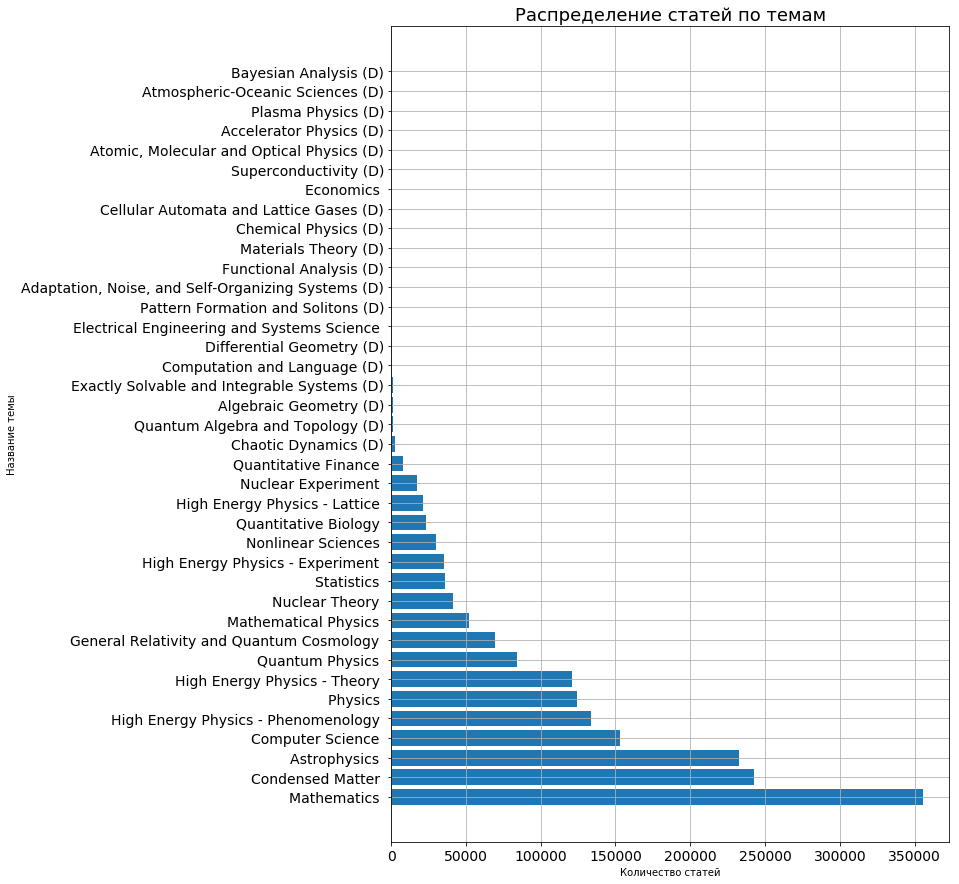

In [4]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
names = [repl_actuals[name] if name in repl_actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.ylabel('Название темы')
plt.xlabel('Количество статей')
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True);

Сделаем замену: старые группы на новые. Таким образом часть мелких групп объединится с уже существующими. Описание [тут](https://arxiv.org/archive/)

In [5]:
for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.GeneralTags]:
        if tag in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
    for tag in old_tags:
        docs[doc][ArxivTags.GeneralTags].remove(tag)

In [6]:
for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.Tags]:
        if tag.split('.')[0] in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.Tags].add(tag)
    for tag in old_tags:
        docs[doc][ArxivTags.Tags].remove(tag)

Ещё раз построим уже модифицированную гистограмму:

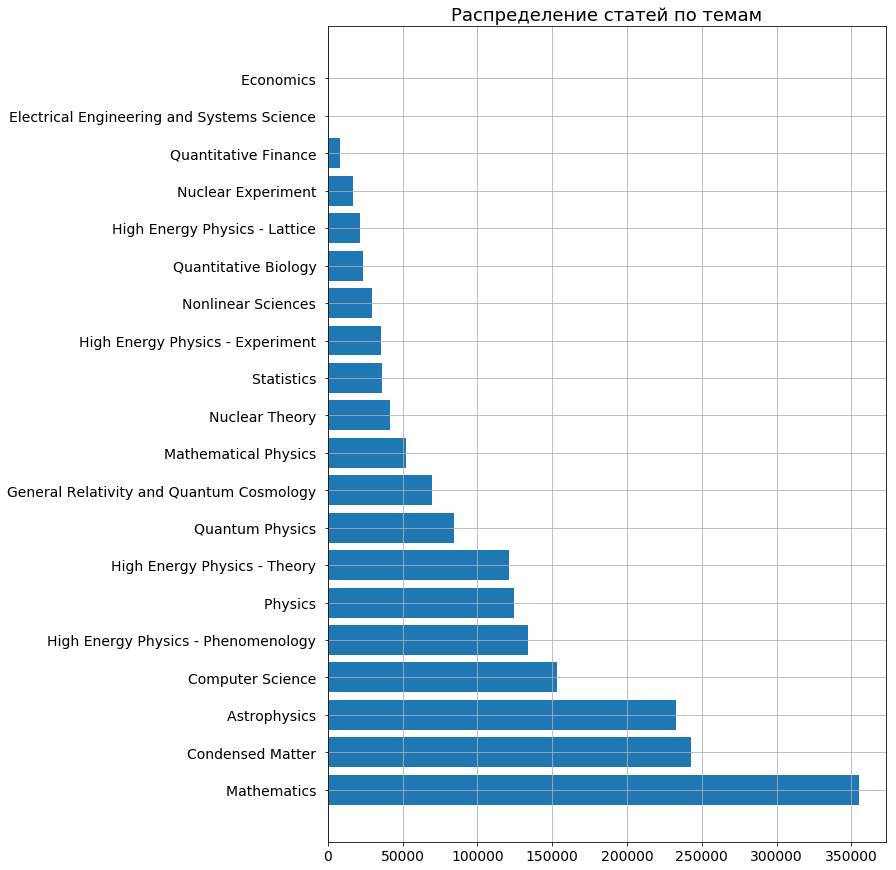

In [7]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True);

Легко заметить, что есть 2 очень малочисленные группы: *Economics* и *Electrical Engineering and Systems Science*. Эти темы появились только с осени 2017 года. Исключим их

In [8]:
# TODO: следует удалить все рёбра, которые ссылаются на статьи eess, econ

docs_for_remove = []
for doc in docs:
    if 'eess' in docs[doc][ArxivTags.GeneralTags] or 'econ' in docs[doc][ArxivTags.GeneralTags]:
        docs_for_remove.append(doc)
        
for doc in docs_for_remove:
    del docs[doc]

Построим модифицированную гистограмму:

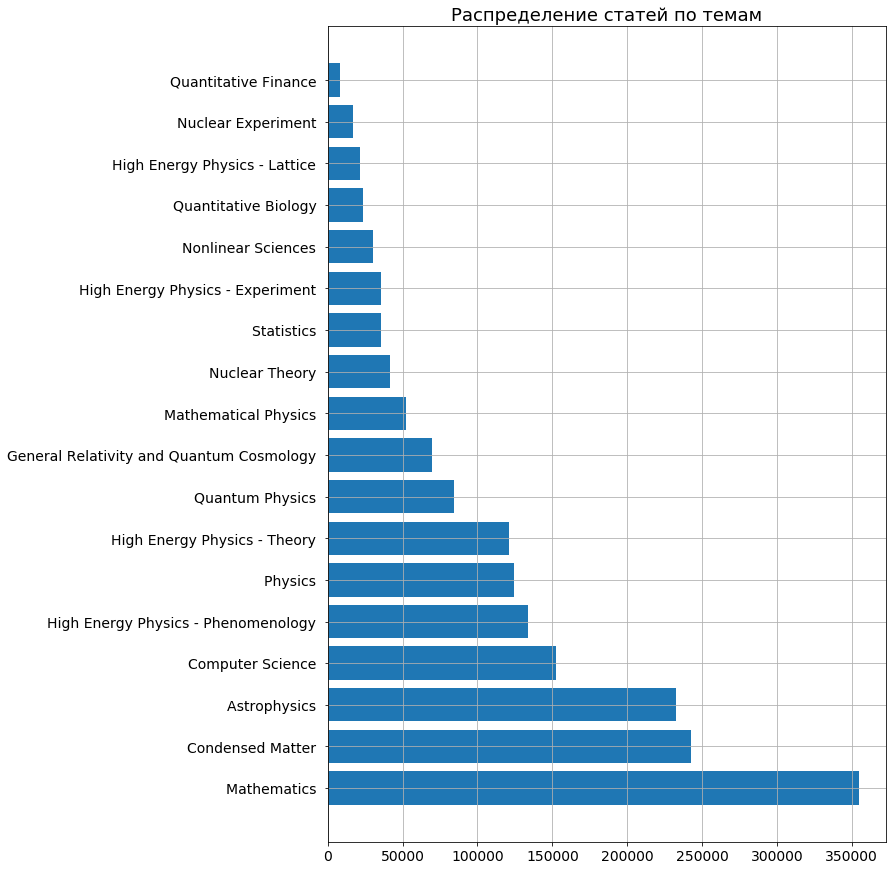

In [9]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True);

### Характеристики графа

Строим граф

In [5]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

In [11]:
cc = list(nx.connected_components(G))

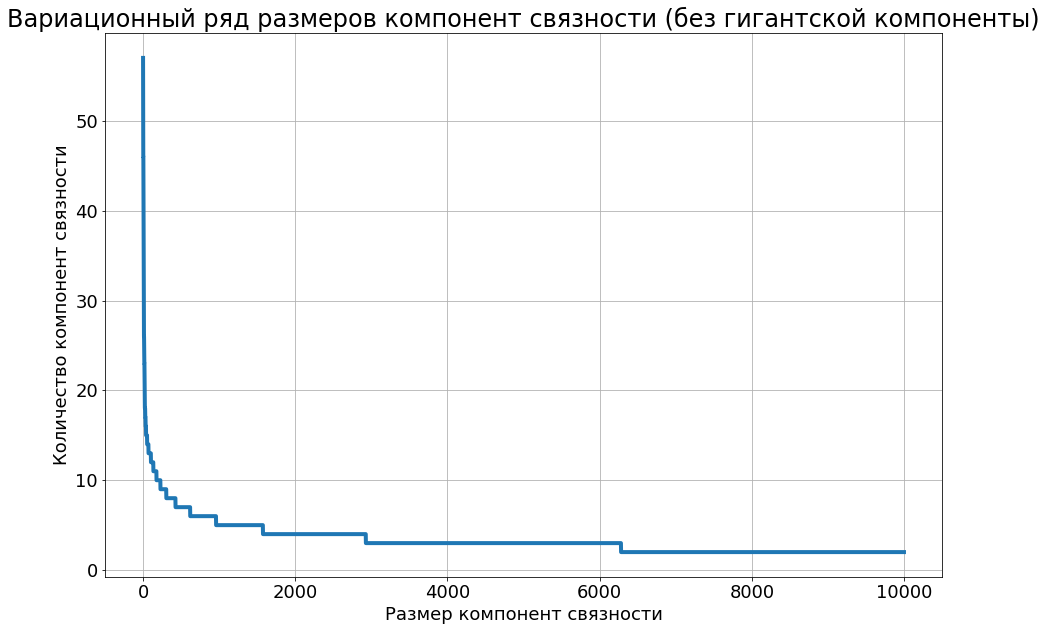

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i) for i in cc])[::-1][1:10000], linewidth=4)
plt.title('Вариационный ряд размеров компонент связности (без гигантской компоненты)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Размер компонент связности', fontsize=18)
plt.ylabel('Количество компонент связности', fontsize=18)
plt.grid(True);

Как видим, существуют достаточно большие компоненты связности (до 50 статей), которые не связаны с гиганской компонентой. Исследуем этот вопрос.

Есть гипотеза, которая связана связанная 

Взглянем на один из кластеров и на авторов, которые писали статьи:

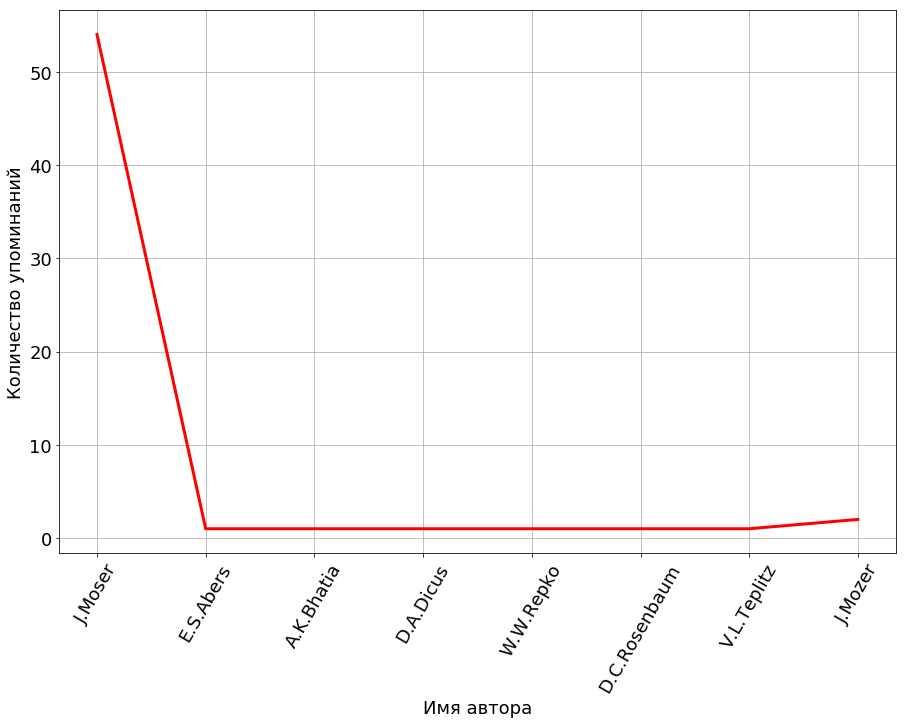

In [22]:
authors = []
clusters = sorted([i for i in cc], key=lambda el: len(el))[::-1]
for name in clusters[1]:
    authors += docs[name][ArxivTags.Authors]
plt.figure(figsize=(15,10))
h = [item[1] for item in Counter(authors).items()]
names = [item[0] for item in Counter(authors).items()]
plt.plot(h, 'r-', linewidth=3)
plt.yticks(fontsize=18)
plt.xticks(list(range(len(names))), names, rotation=60, fontsize=18)
plt.xlabel('Имя автора', fontsize=18)
plt.ylabel('Количество упоминаний', fontsize=18)
plt.grid(True);

Очевидно, что автор со совими преспешниками пилит статьи и мало интересуется, что происходит вокруг него (скорее всего).

Теперь давайте агрегируем информацию о том, как же формируются такого рода кластеры. Для этого будем считать долю статей в кластере, в которых упоминался идейный вдохновитель написания статей (т.е. тот автор, который чаще других упоминается в кластере). Если размер кластера меньше 5, то такие кластеры учитывать не будем.

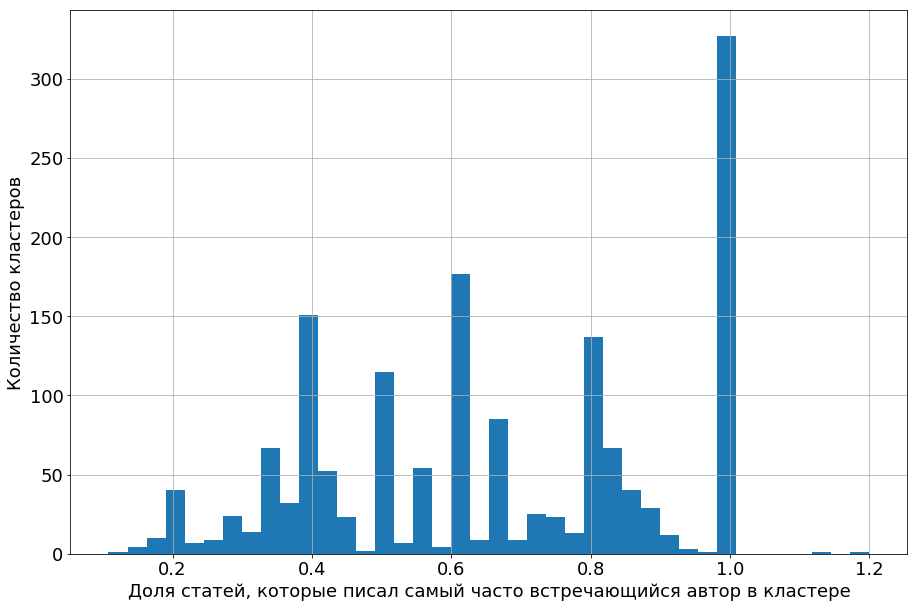

In [23]:
clusters = sorted(cc, key=lambda el: len(el))[::-1]
noise = []
count_papers = []
for cluster in clusters[1:]:
    authors = []
    count = 0
    if len(cluster) < 5:
        break
    for name in cluster:
        authors += docs[name][ArxivTags.Authors]
        count += 1
    noise.append([item[1] for item in Counter(authors).items()])
    count_papers.append(count)
    
max_author = []
for n, c in zip(count_papers, noise):
    max_author.append(max(c) / n)

plt.figure(figsize=(15, 10))
plt.hist(max_author, bins=40)
plt.ylabel('Количество кластеров', fontsize=18)
plt.xlabel('Доля статей, которые писал самый часто встречающийся автор в кластере', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True);

Как видим, одна из гипотез может объяснить, почему существуют малкие кластеры. Есть достаточно много авторов, которые упоминаются во всех статьях (пик в точке 1), а также есть достаточное количество авторов, которые очень во многих статьях из кластера являются авторами. Немного изучив творчество этих людей, я пришёл к выводу, что такие авторы чаще всего изучают очень узкие области знаний, либо же, [описывают ПО](https://arxiv.org/pdf/1604.00025.pdf). Например, Jan Moser изучает свойства рядов, которые, судя по всем, интересуют только его.

Некоторые люди предлагают подходы к изучению тех или иных областей знаний. Например, в [стаье](https://arxiv.org/pdf/quant-ph/9907033.pdf) предлагают какой-то особенной подход к изучению свойств квантовых систем. Но в сети о нём ничего найти не удалось. Кажется, что данная идея не плодотворна.

Но также есть [статья](https://arxiv.org/pdf/1408.1121.pdf), в которой присутствует огромное количество ссылок на работы различных людей. Так что, очевидно, данные кластеры порождаются, в том числе ограниченностью датасета: ссылки в данном датасете представлены только на статьи внутри arxiv и это сильное ограничение.

Стоит отметить, что существует огромное количество одиночных кластеров, которые, вероятно, возникают из-за способа обработки, а также из-за наличия ссылок, которые ведут во вне arxiv

In [32]:
def get_triangle(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        for v2 in G.neighbors(v1):
            if v2 == v0:
                vertexes.append(v1)
    return vertexes

def custom_plot(x, y, title, ylabel, xlabel='Число вершин', font=18, title_font=24, linewidth=4, markersize=10):
    plt.figure(figsize=(15, 10))
    plt.plot(x, y, 'b-', linewidth=linewidth)
    plt.plot(x, y, 'ro', markersize=markersize)
    plt.title(title, fontsize=title_font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel(xlabel, fontsize=font)
    plt.ylabel(ylabel, fontsize=font)
    plt.grid(True)

In [25]:
count_K3 = []
sizes_subgraph = [5, 100, 5000, 10000, 50000, 100000, 200000, 500000, 750000, 1000000, len(G.nodes)]
proporion = 0.1
vertexes = list(G.nodes)
for n in tqdm_notebook(sizes_subgraph):
    perm = np.random.permutation(len(G.nodes))
    random_vertex = list(np.array(vertexes)[perm])[:n]
    subgraph = G.subgraph(random_vertex)
    count = 0
    for v in random_vertex[:int(n * proporion)]:
        count += len(get_triangle(subgraph, v))
    count_K3.append(count)
del vertexes
del subgraph

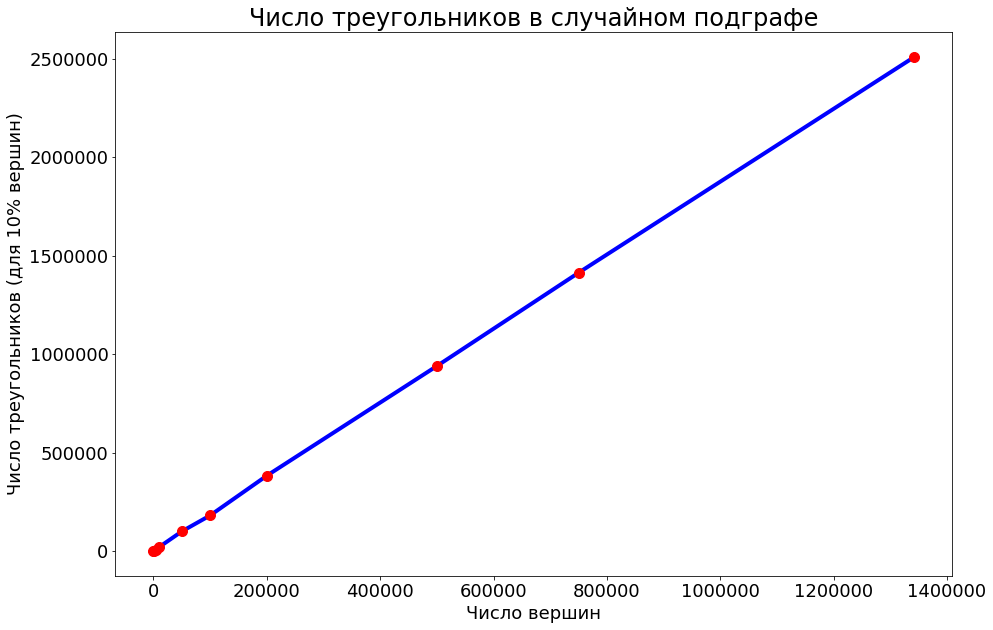

In [26]:
custom_plot(
    sizes_subgraph, count_K3,
    'Число треугольников в случайном подграфе',
    'Число треугольников (для 10% вершин)'
)

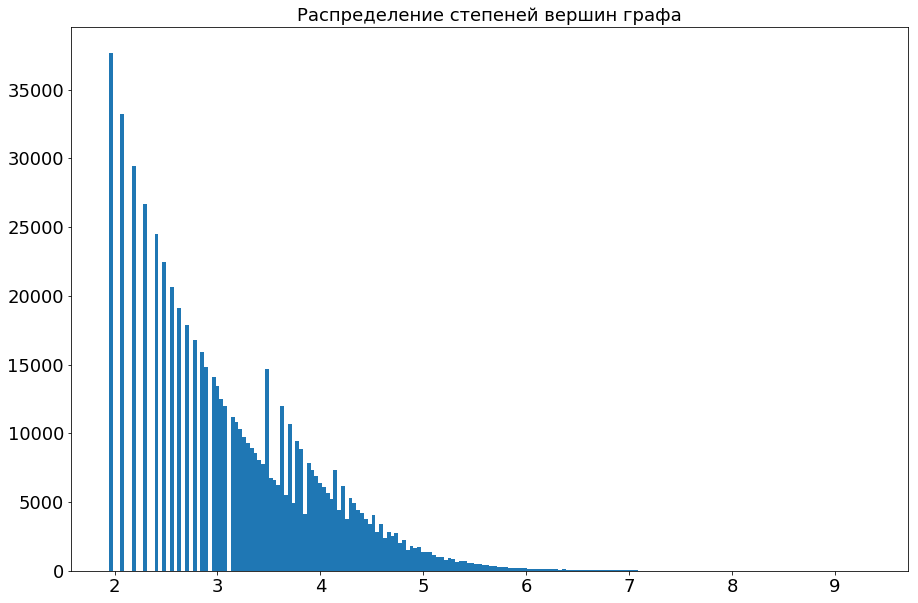

In [36]:
degs = []
for item in G.degree:
    degs.append(item[1])

plt.figure(figsize=(15,10))
plt.title('Распределение степеней вершин графа', fontsize=18)
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(np.log1p(np.array(degs)[np.array(degs) > 5]), bins=200);

In [37]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, 1000000, len(G.nodes)]
m_cv = 5
vertexes = list(G.nodes)
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = list(np.array(vertexes)[perm])[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

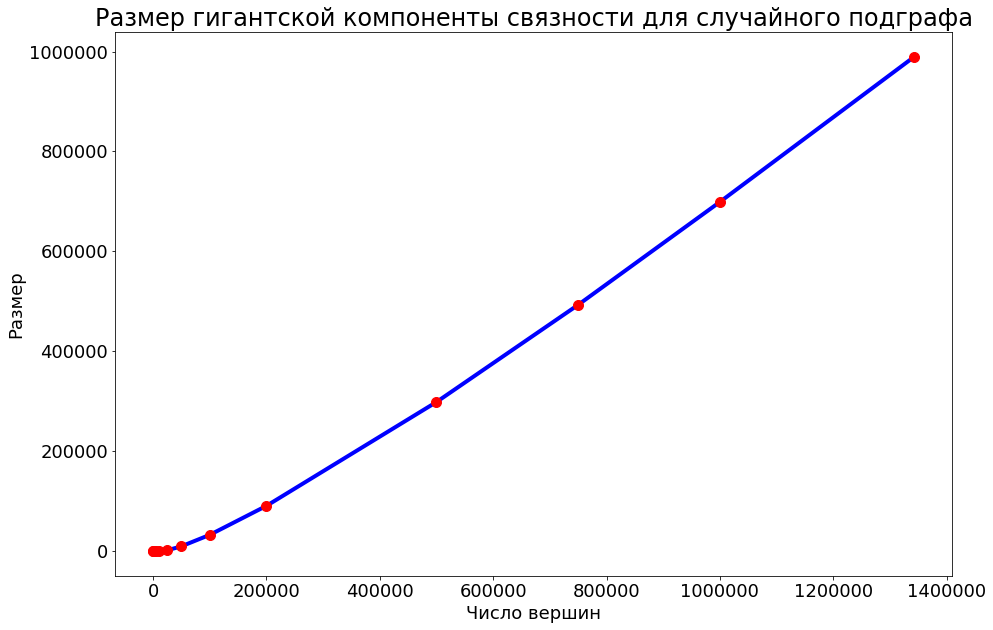

In [38]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

Модель малого мира выполняется. Данный граф представляет собой большую компоненту, которая разростается с ростом числа вершин. Это и понятно: большее число статей охватывает большее количе

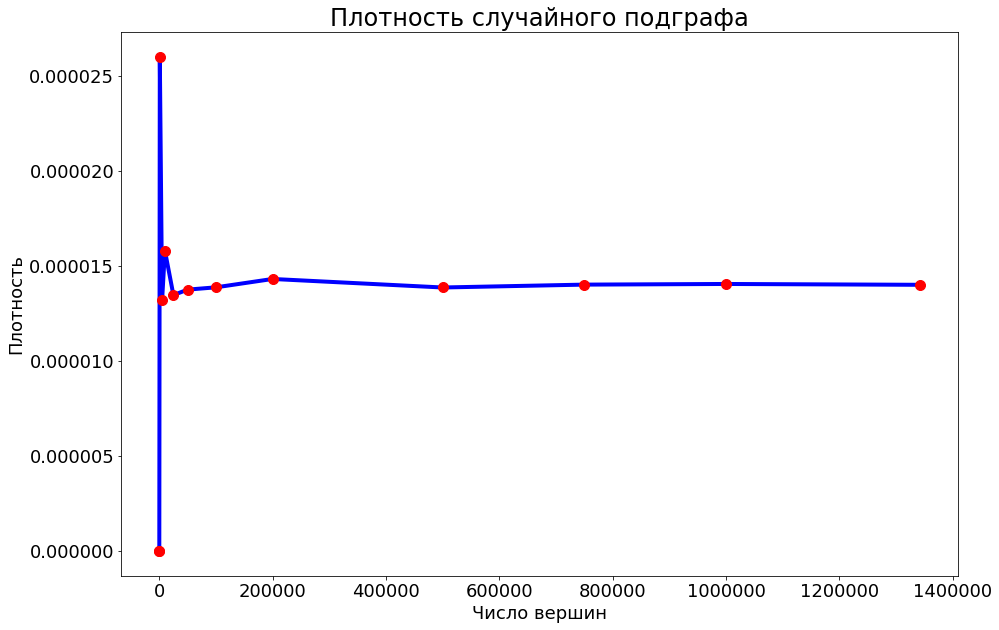

In [39]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

Отметим, что после того, как мы убрали "мелкие" кластеры, плотность графа выросла на 2 порядка

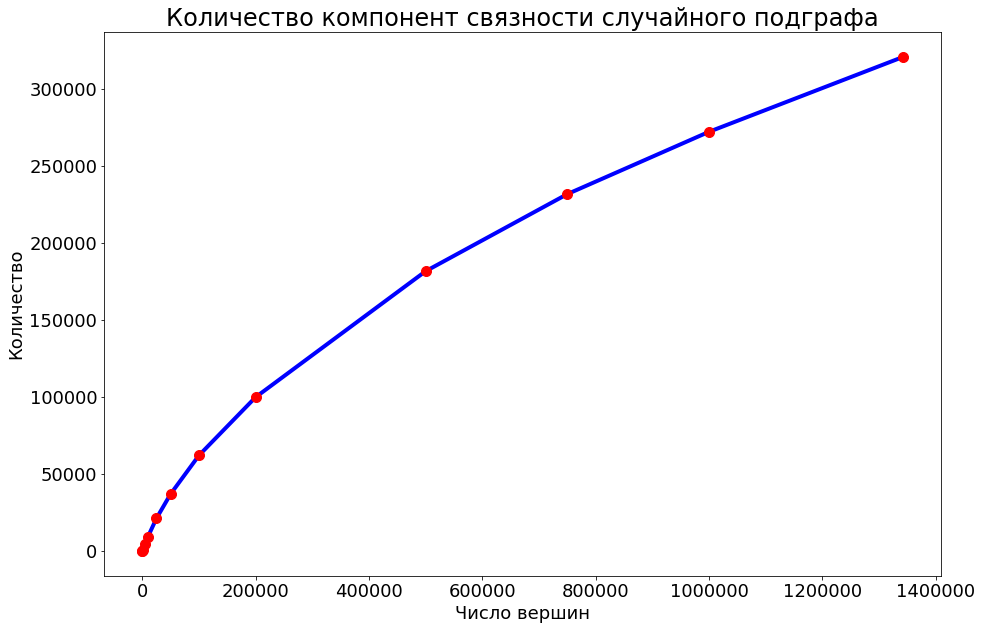

In [40]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

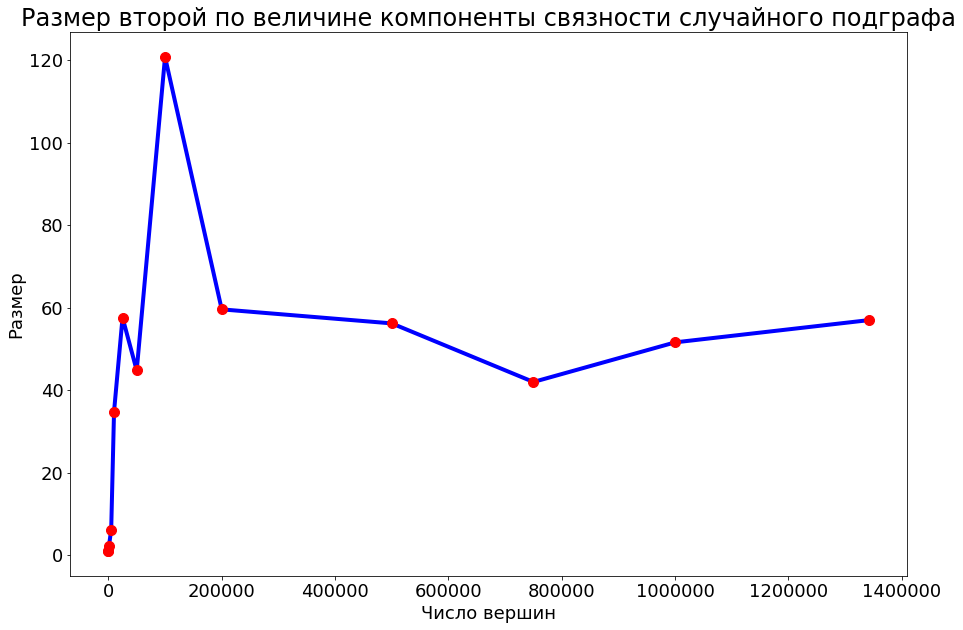

In [41]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

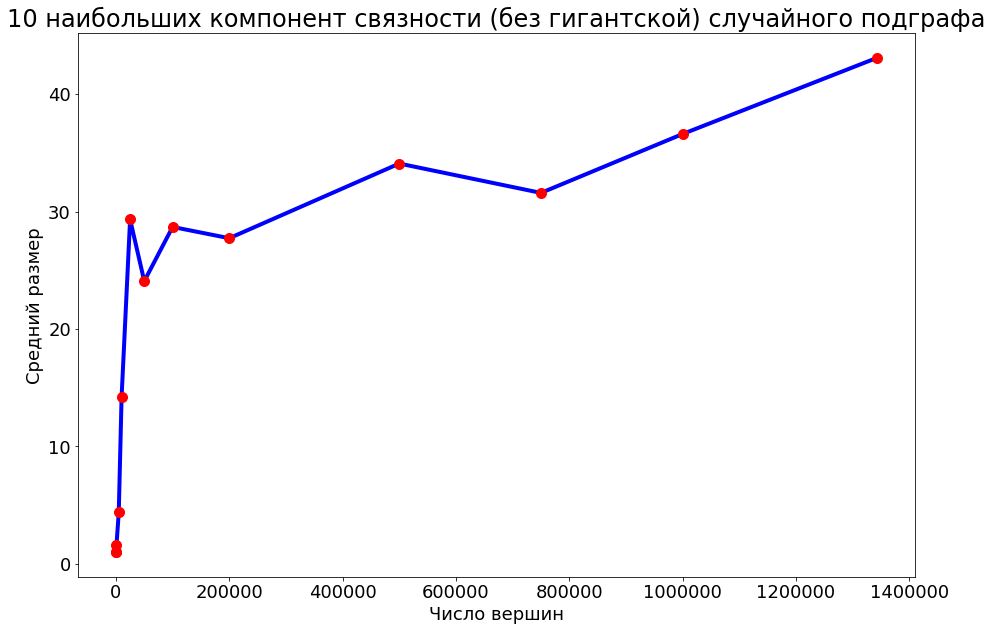

In [42]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

In [14]:
cc = sorted([c for c in list(nx.connected_components(G))], key=lambda el: len(el))[::-1][1:]
flatten_cc = []
for c in cc:
    for x in c:
        flatten_cc.append(x)
v_for_deleted = set(flatten_cc)

for doc in docs:
    edges = []
    for v in docs[doc][ArxivTags.Edges]:
        if v not in v_for_deleted:
            edges.append(v)
    docs[doc][ArxivTags.Edges] = edges
    
for doc in v_for_deleted:
    del docs[doc]
    
del cc
del flatten_cc
del v_for_deleted

In [19]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

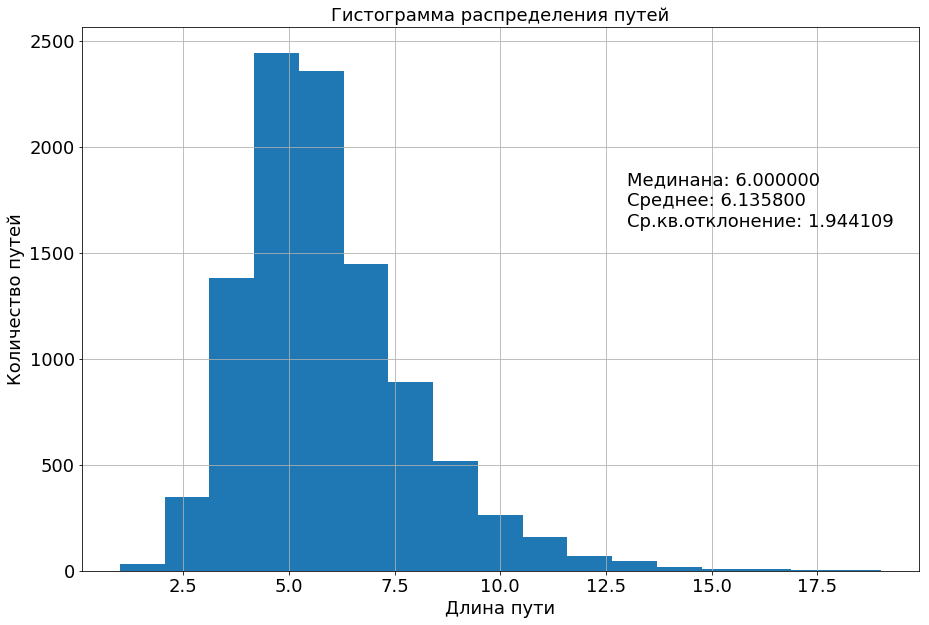

In [20]:
vertexes = list(G.nodes)
n_cv = 10000
len_paths = []
np.random.seed(42)
for i in tqdm_notebook(range(n_cv)):
    a = np.random.randint(len(vertexes))
    b = np.random.randint(len(vertexes))
    len_paths.append(nx.shortest_path_length(G, source=vertexes[a], target=vertexes[b]))
del vertexes

plt.figure(figsize=(15, 10))
plt.hist(len_paths, bins=17)
plt.grid(True)
plt.ylabel('Количество путей', fontsize=18)
plt.xlabel('Длина пути', fontsize=18)
plt.title('Гистограмма распределения путей', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.text(13, 1820, 'Мединана: %f' % np.median(len_paths), fontsize=18)
plt.text(13, 1720, 'Среднее: %f' % np.mean(len_paths), fontsize=18);
plt.text(13, 1620, 'Ср.кв.отклонение: %f' % np.sqrt(np.var(len_paths)), fontsize=18);

# Анализ графа по времени

In [64]:
del docs
del G

In [65]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:24<00:00,  1.15s/it]


In [26]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

In [27]:
docs_by_years = {}
for year in range(1991, 2018):
    docs_by_years[year] = []

for doc in docs:
    docs_by_years[docs[doc][ArxivTags.Year]].append(doc)

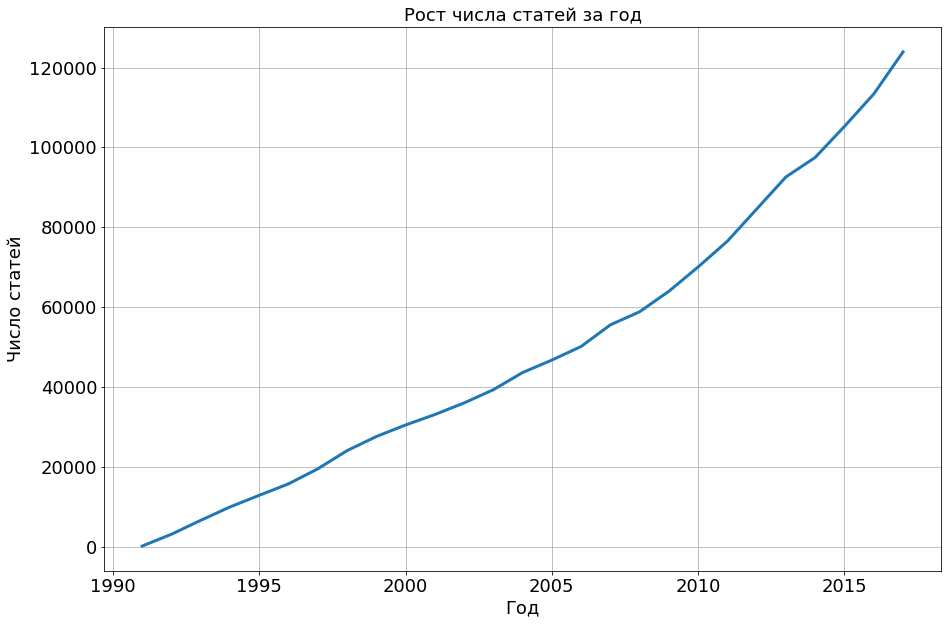

In [28]:
counts = [len(docs_by_years[y]) for y in docs_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts, linewidth=3)
plt.grid(True)
plt.ylabel('Число статей', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Рост числа статей за год', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

In [29]:
sorted_by_year_docs = []

for doc in docs:
    splitted = doc.split('/')
    if len(splitted) == 2:
        splitted = splitted[1]
        if int(splitted[:2]) > 90:
            year = 1900 + int(splitted[:2])       
        else:
            year = 2000 + int(splitted[:2])       
        year_month = year * 100 + int(splitted[2:4])
        year_month_num = year_month * 10000 + int(splitted[4:])
        year_month_num_r = year_month_num * 1000 + np.random.randint(100)
        sorted_by_year_docs.append((doc, year_month_num_r))
    else:
        splitted = splitted[0].split('.')
        a = splitted[0]
        b = splitted[1]
        year = 2000 + int(a[:2])       
        year_month = year * 100 + int(a[2:4])
        year_month_num = year_month * 100000 + int(b)
        sorted_by_year_docs.append((doc, year_month_num * 100))

In [30]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, 1000000, len(G.nodes)]
vertexes = list([item[0] for item in sorted_by_year_docs])
m_cv = 5
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = vertexes[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

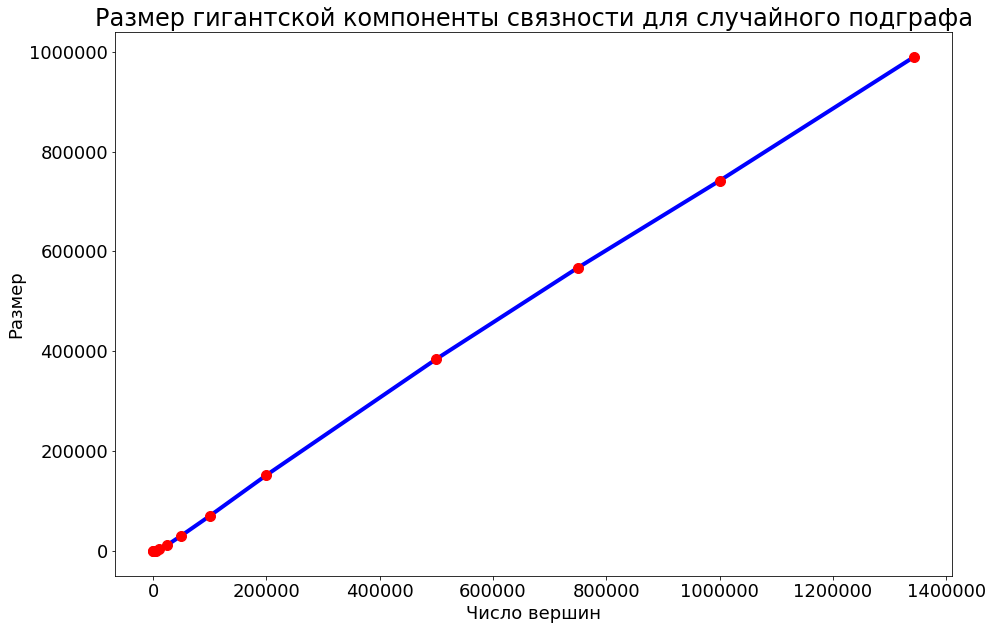

In [33]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

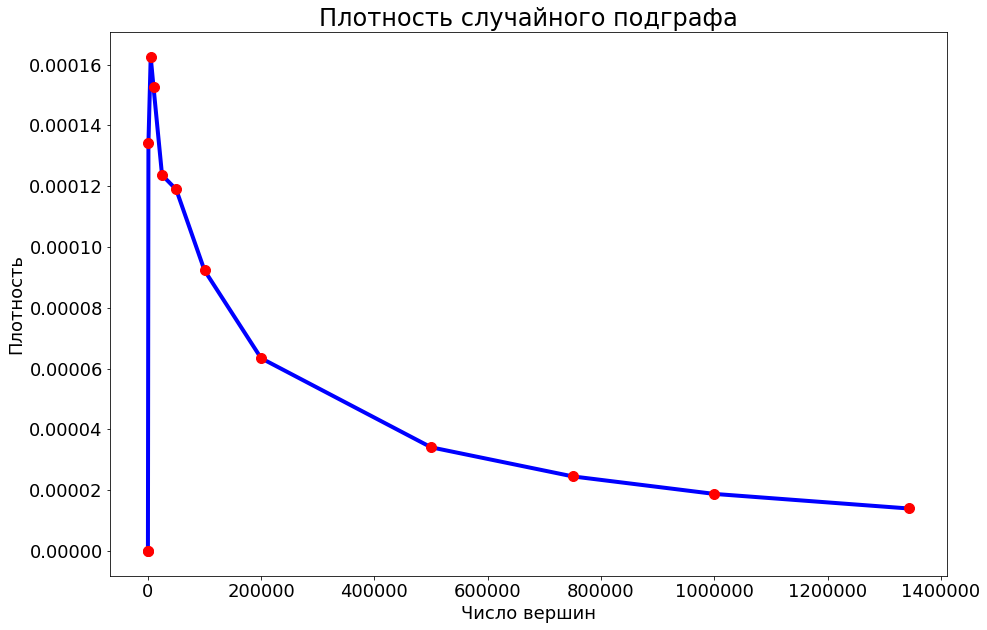

In [34]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

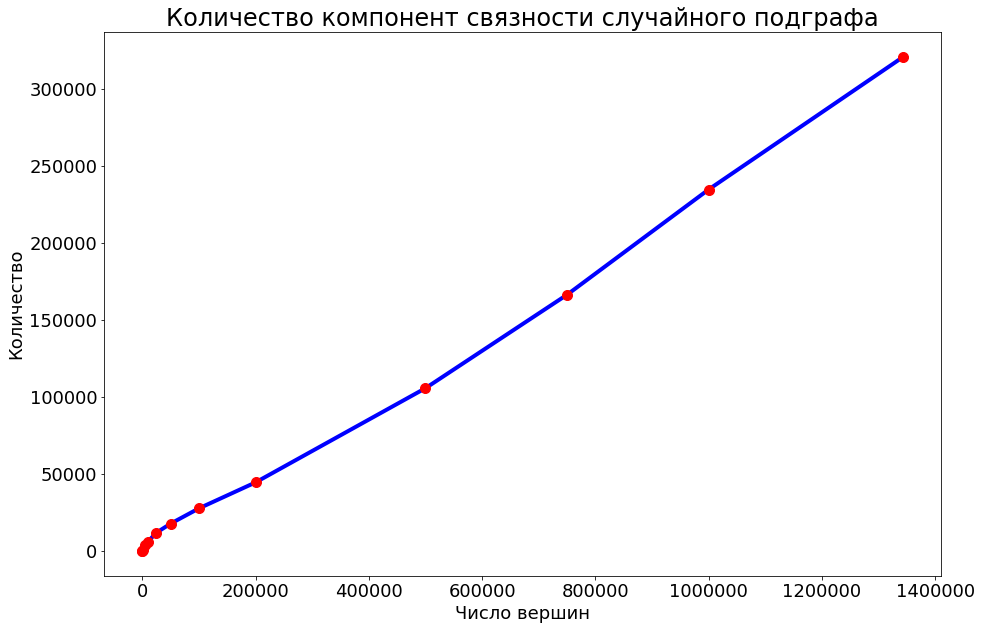

In [35]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

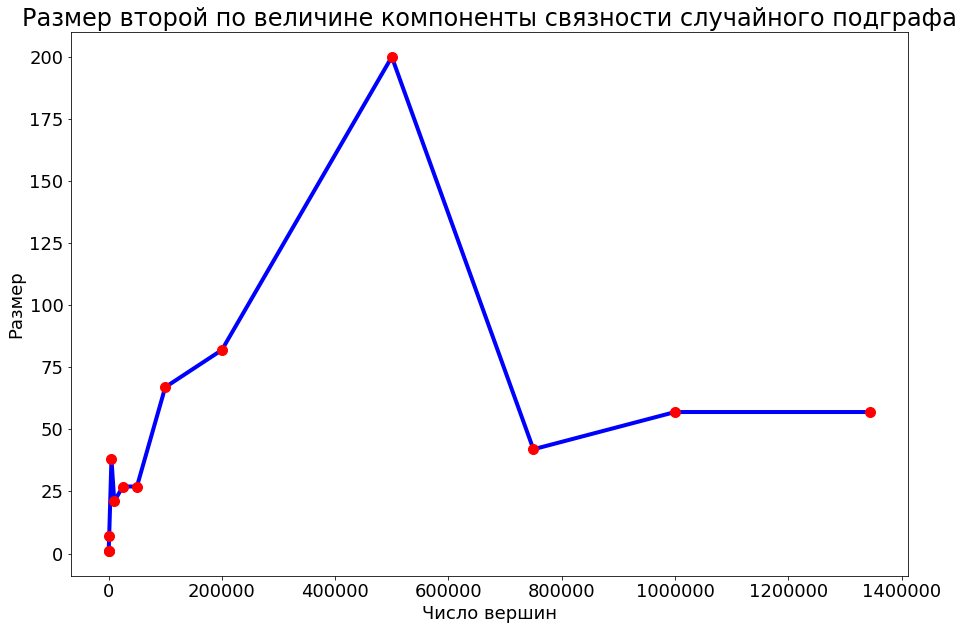

In [36]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

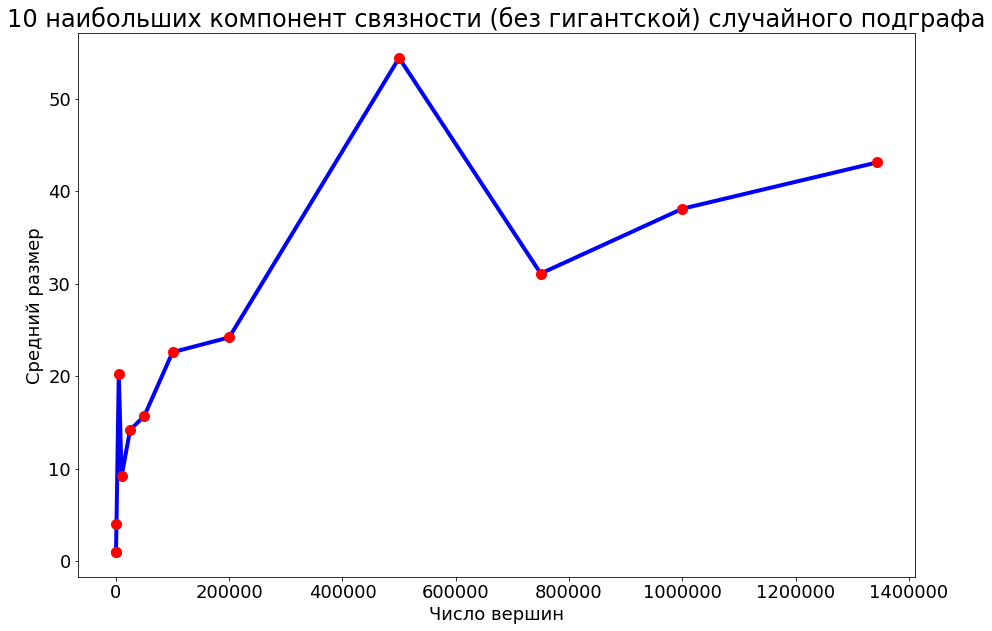

In [37]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

In [70]:
del docs

In [71]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:20<00:00,  1.22s/it]


In [72]:
for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.GeneralTags]:
        if tag in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
    for tag in old_tags:
        docs[doc][ArxivTags.GeneralTags].remove(tag)

for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.Tags]:
        if tag.split('.')[0] in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.Tags].add(tag)
    for tag in old_tags:
        docs[doc][ArxivTags.Tags].remove(tag)

In [75]:
theme_g = nx.Graph()
for doc in tqdm_notebook(docs):
    tags0 = docs[doc][ArxivTags.GeneralTags]
    tags1 = []
    for v in docs[doc][ArxivTags.Edges]:
        tags1 += docs[v][ArxivTags.GeneralTags]
    for t0 in tags0:
        if t0 in ['eess', 'econ']:
            continue
        for t1 in tags1:
            if t1 in ['eess', 'econ']:
                continue
            if theme_g.has_edge(t0, t1):
                theme_g[t0][t1]['weight'] += 1
                theme_g[t1][t0]['weight'] += 1
            else:
                theme_g.add_edge(t0, t1, weight=1)
                theme_g.add_edge(t1, t0, weight=1)

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


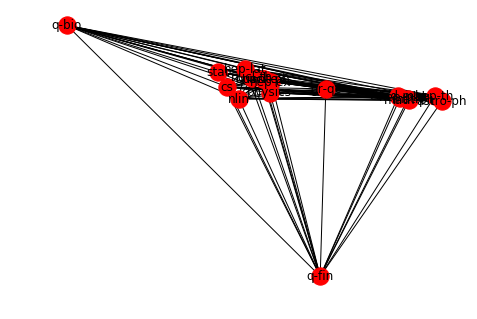

In [76]:
nx.draw(theme_g, with_labels=True)

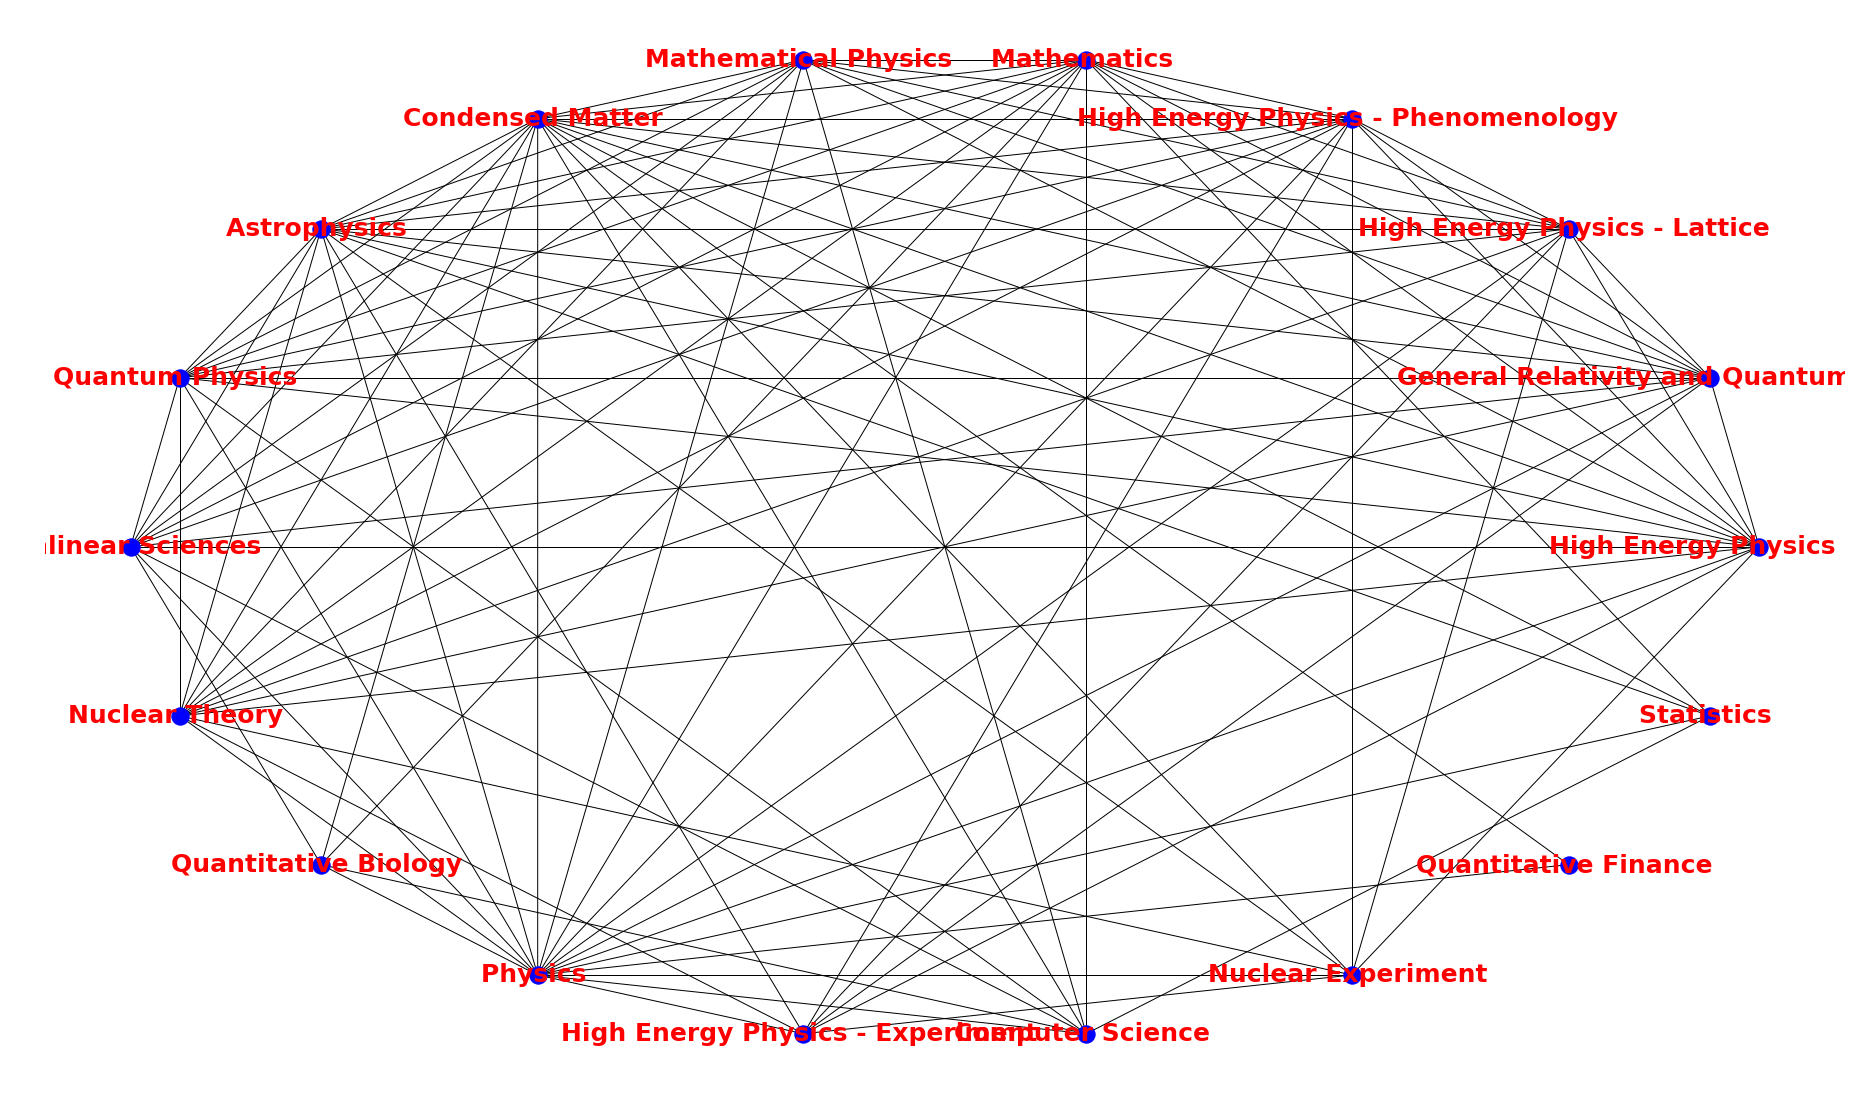

In [183]:
from copy import deepcopy
theme_g_new = deepcopy(theme_g)
theme_g_new = nx.relabel_nodes(theme_g_new, actuals)
t = 1000
for n0 in theme_g_new.nodes:
    for n1 in theme_g_new.nodes:
        if n1 in theme_g_new[n0] and theme_g_new[n0][n1]['weight'] < 10000:
            theme_g_new.remove_edge(n0, n1)
            
plt.figure(figsize=(25,15))
theme_g_new.remove_nodes_from(list(nx.isolates(theme_g_new)))
nx.draw_shell(theme_g_new, with_labels=True, font_size=25, font_color='red', font_weight=1000, node_color='blue')

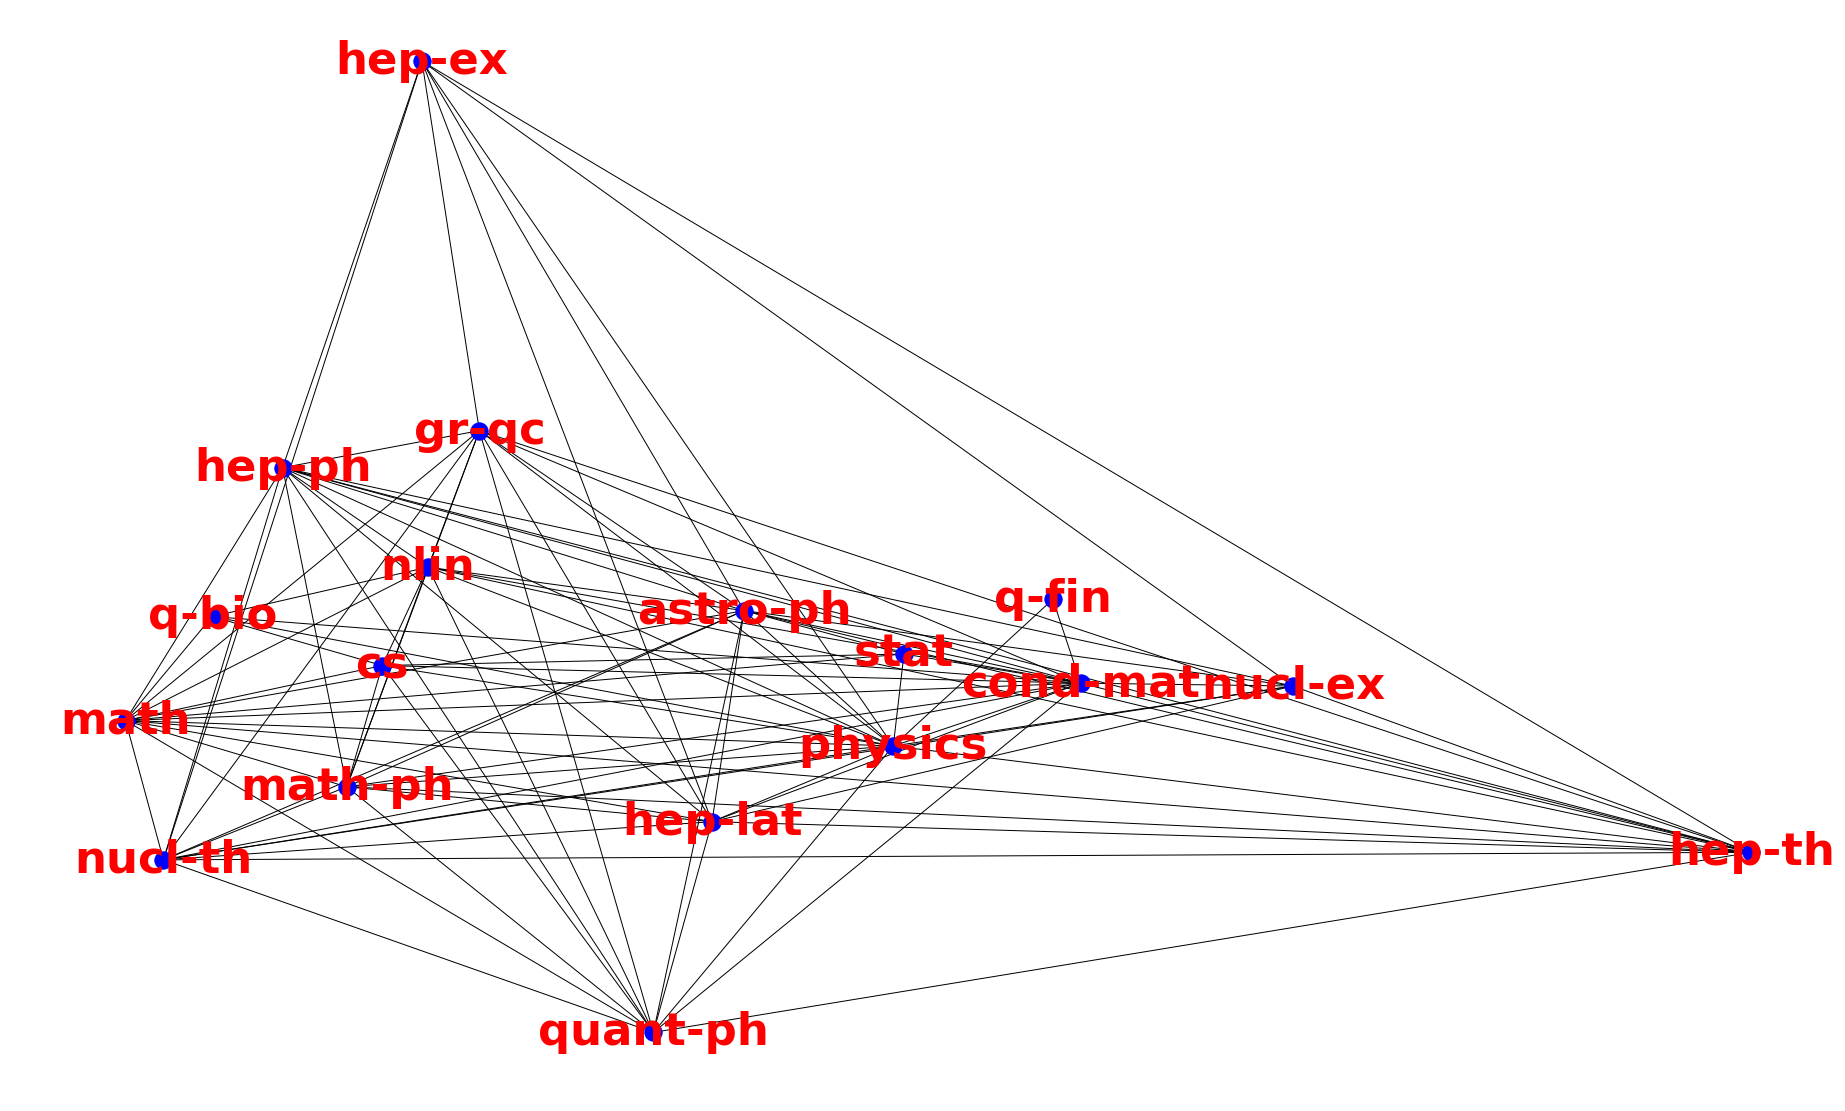

In [189]:
theme_g_new = nx.relabel_nodes(theme_g_new, {item[1]:item[0] for item in actuals.items()})

plt.figure(figsize=(25,15))
nx.draw_kamada_kawai(theme_g_new, with_labels=True, font_size=45, font_color='red', font_weight=1000, node_color='blue')